In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data


# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate helical fraction
def betastrand_fraction(ss_line):
    beta_chars = {'E', 'B'}
    n_residues = len(ss_line)
    n_beta = sum(1 for c in ss_line if c in beta_chars)
    return n_beta / n_residues

# function to calculate PPII content
def PPII_fraction(ss_line):
    helix_chars = {'P'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

def md_stabilization_times(time, values, errors=None, rtol_val=0.1, rtol_err=0.1, window=5):
    """
    Determine the time points where values and errors have stabilized.
    
    Stabilization is defined as the first time where:
      - Relative change of the value over a window falls below rtol_val
      - Error relative to the value falls below rtol_err

    Parameters
    ----------
    time : array-like
        Time points of the series.
    values : array-like
        Cumulative average values as a function of time.
    errors : array-like, optional
        Errors as a function of time.
    rtol_val : float, optional
        Relative tolerance for value stabilization.
    rtol_err : float, optional
        Relative tolerance for error stabilization (as fraction of value).
    window : int, optional
        Number of points over which to compute relative change.

    Returns
    -------
    t_value_stable : float
        First time where values have stabilized.
    t_error_stable : float or None
        First time where errors have stabilized (None if errors not provided).
    """

    time = np.asarray(time)
    values = np.asarray(values)

    def first_value_stable(series, rtol=rtol_val):
        for i in range(len(series) - window):
            window_vals = series[i:i+window]
            rel_change = np.ptp(window_vals) / (np.mean(window_vals) + 1e-12)
            if rel_change <= rtol:
                return time[i]
        return time[-1]

    t_value_stable = first_value_stable(values)

    t_error_stable = None
    if errors is not None:
        errors = np.asarray(errors)
        # Stabilization when error/value <= rtol_err
        rel_err = errors / (np.abs(values) + 1e-12)
        for i in range(len(rel_err) - window):
            if np.all(rel_err[i:i+window] <= rtol_err):
                t_error_stable = time[i]
                break
        else:
            t_error_stable = time[-1]

    return t_value_stable, t_error_stable


def md_stabilization_times_helixprofilermsd(time, values, errors, rtol_val=0.02, rtol_err = 0.02):
    """
    Determine the time points where values have stabilized.
    
    Stabilization is defined as the first time where:
      - The RMSD to the full ensemble helix profile falls below rtol
      - The average error falls below rtol_err

    Parameters
    ----------
    time : array-like
        Time points of the series.
    values : array-like
        Cumulative average values as a function of time.
    errors : array-like
        Average error per-residue as a function of time.
    rtol_val : float, optional
        Relative tolerance for value stabilization.
    rtol_err : float, optional
        Relative tolerance for error stabilization.
    window : int, optional
        Number of points over which to compute relative change.

    Returns
    -------
    t_value_stable : float
        First time where values have stabilized.
    t_error_stable : float
        First time where average per-residue error falls below threshold.
    """

    time = np.asarray(time)
    values = np.asarray(values)
    errors = np.asarray(errors)

    try:
        t_value_stable = time[np.where(values<rtol_val)[0][0]]
    except:
        t_value_stable = time[len(values)-1]

    try:
        t_error_stable = time[np.where(errors<rtol_err)[0][0]]
    except:
        t_error_stable = time[len(values)-1]

    return t_value_stable, t_error_stable


output_path = './plots_unb_ACTR/'
prod_name = '300K'
path = '../Unbiased_MD/ACTR/'
path_biased = '../OPES_multiT/ACTR/NEW_PRODUCTION_300K_2fs_80steps/alldata/'
opes_data_path = './plots_ACTR/'

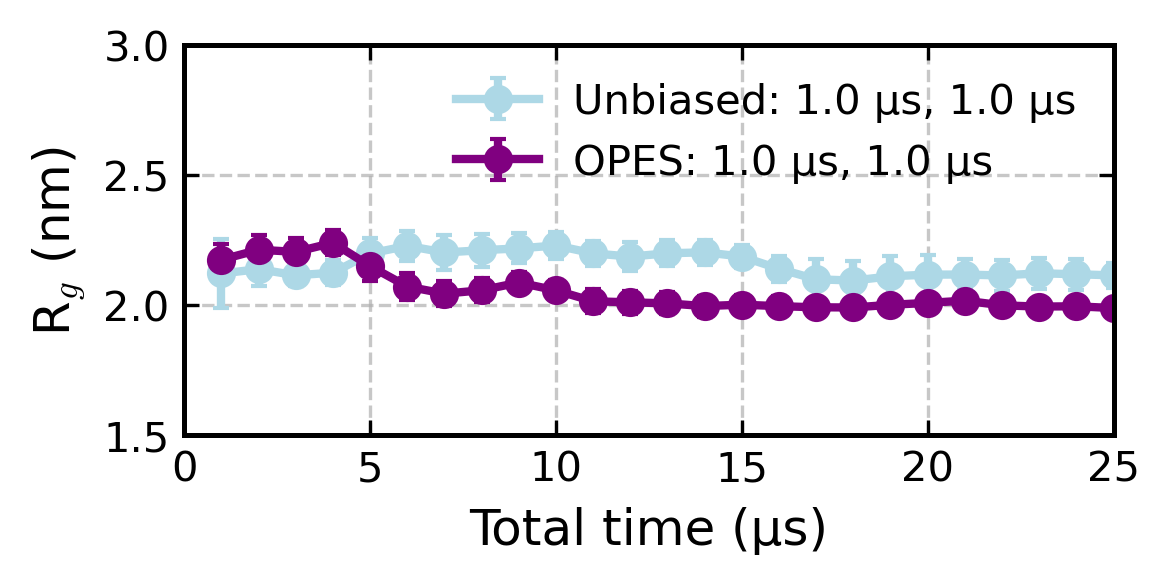

In [4]:
# Avg rg and std error of Rg as a function of sim time per replicate
# two plot panels: top shows the avg Rg as a function of time and bottom shows the std error as a function of time

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nreplicas = 1
nsims_unb = 3
nrep_opes = 5
total_length_us = 25

times = np.arange(1.0, 25.0 + 1.0, 1.0) # times to check in μs

averages = []
errors = []
error_errors = []

for time in times:

    for sim in range(nsims_unb):
        if sim==0:
            # load data and concatenate (and plot distributions of individual trajectories)
            CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        else:
            tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
            CVS = np.concatenate((CVS, tmpCVS), axis=0)

    time_data = np.arange(CVS.shape[0])/1e3       # ps -> μs
    # Apply cutoff at time
    mask_data = time_data <= time
    CVS =  CVS[mask_data]

    # rg of concatenated trajs
    rgdata = CVS[:,1]

    # append data
    averages.append(np.average(rgdata, axis=0))
    reblocked = pyblock.blocking.reblock(rgdata)  # default no weights
    try:
        opt = int(pyblock.blocking.find_optimal_block(len(rgdata), reblocked)[0])
    except:
        allerrs = np.array([reblocked[ele].std_err for ele in range(len(reblocked))])
        opt = np.where(allerrs==np.max(allerrs))[0][0]
    if opt==len(reblocked)-1:
        opt=opt-1
    stderr_bin = reblocked[opt].std_err
    errors.append(stderr_bin)
    error_errors.append( reblocked[opt].std_err_err)


# save results
df = pd.DataFrame()
df['Time (μs)'] = np.round(times, 3)
df['Rg (nm)'] = np.round(averages, 5)
df['±'] = np.round(errors, 5)
df['Err ±'] = np.round(error_errors, 5)
df.to_csv(output_path+f'{prod_name}_rg_vs_time_convergene_{T}K.csv')

# convergence times
conv_val, conv_err = md_stabilization_times(times*nreplicas, averages, errors)

# load opes results
dfopes = pd.read_csv(opes_data_path+f'300K_rg_vs_time_convergene_{T}K.csv')
conv_val_opes, conv_err_opes = md_stabilization_times(dfopes['Time (μs)']*nrep_opes, dfopes['Rg (nm)'], dfopes['±'])

# plot results
plt.figure(figsize = (4,3.5))

ticks=np.round(np.arange(0, total_length_us+total_length_us//5, total_length_us//5), 0)

plt.subplot(2,1,1)
plt.errorbar(times * nreplicas, averages, errors, fmt= 'o-', color ='lightblue', capsize = 2, label = f'Unbiased: {conv_val:.1f} μs, {conv_err:.1f} μs')
plt.errorbar(dfopes['Time (μs)']*nrep_opes, dfopes['Rg (nm)'], dfopes['±'], fmt= 'o-', color ='purple', capsize = 2, label = f'OPES: {conv_val_opes:.1f} μs, {conv_err_opes:.1f} μs')
plt.xlim(0, 25)
plt.ylim(1.5, 3.0)
plt.ylabel('R$_g$ (nm)')
plt.xticks(ticks=ticks, labels = ticks)
plt.xlabel('Total time (μs)')
plt.legend()

'''
plt.subplot(2,1,2)
plt.errorbar(times * nreplicas, errors, error_errors, fmt= 'o-', color ='#DA70D6', capsize = 2)
plt.errorbar(dfopes['Time (μs)']*nrep_opes, dfopes['±'], dfopes['Err ±'], fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 15)
plt.ylim(0, 0.05)
plt.ylabel('Error (nm)')
plt.xlabel('Total time (μs)')
plt.xticks(ticks=ticks, labels = ticks)
'''

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_rg_vs_time_convergene_{T}K.pdf")

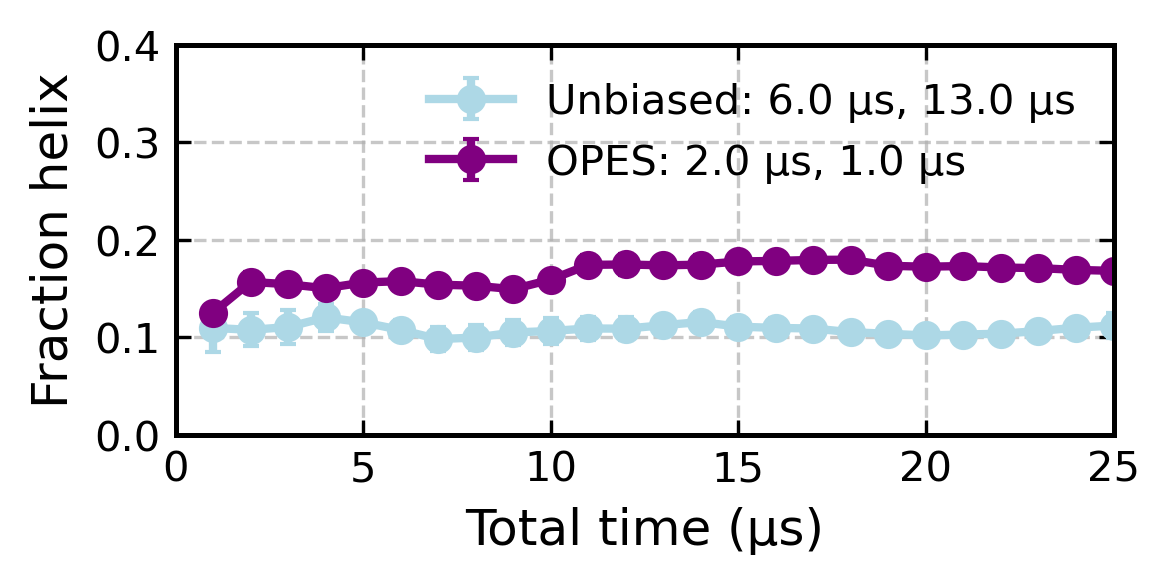

In [10]:
# time convergence of average  fraction helix of the ensemble (averaged )

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nreplicas = 1
nsims_unb = 3
nrep_opes = 5
total_length_us = 25

times = np.arange(1.0, 25.0 + 1.0, 1.0) # times to check in μs

averages = []
errors = []
error_errors = []

# exclude last 4 dssp characters due to weird pdb formatting of the DESRES traj
for time in times:

    for sim in range(nsims_unb):
        if sim==0:
            # load data and concatenate       
            with open(path+f'dssp{sim}.dat') as f:
                dssp = [line.strip()[:-4] for line in f]
            dssp =  np.array(dssp)
        else:
            # load data and concatenate       
            with open(path+f'dssp{sim}.dat') as f:
                tmpdssp = [line.strip()[:-4] for line in f]
            tmpdssp =  np.array(tmpdssp)
            dssp = np.concatenate((dssp, tmpdssp), axis=0)
    # Time arrays in μs
    time_data = np.arange(len(dssp))/1e3       # ps -> μs
    # Apply cutoff at time
    mask_data = time_data <= time
    dssp =  np.array(dssp)[mask_data]

    # Compute helical fraction for each frame
    helical_frac = np.array([helical_fraction(frame) for frame in dssp])

    # append data
    averages.append(np.average(helical_frac, axis=0))
    reblocked = pyblock.blocking.reblock(helical_frac)  # default no weights
    try:
        opt = int(pyblock.blocking.find_optimal_block(len(helical_frac), reblocked)[0])
    except:
        allerrs = np.array([reblocked[ele].std_err for ele in range(len(reblocked))])
        opt = np.where(allerrs==np.max(allerrs))[0][0]
    if opt==len(reblocked)-1:
        opt=opt-1
    stderr_bin = reblocked[opt].std_err
    errors.append(stderr_bin)
    error_errors.append( reblocked[opt].std_err_err)




# save results
df = pd.DataFrame()
df['Time (μs)'] = np.round(times, 3)
df['Fraction helix'] = np.round(averages, 5)
df['±'] = np.round(errors, 5)
df['Err ±'] = np.round(error_errors, 5)
df.to_csv(output_path+f'{prod_name}_HelicalFrac_vs_time_convergene_{T}K.csv')

# convergence times
conv_val, conv_err = md_stabilization_times(times*nreplicas, averages, errors)

# load opes results
dfopes = pd.read_csv(opes_data_path+f'300K_HelicalFrac_vs_time_convergene_{T}K.csv')
conv_val_opes, conv_err_opes = md_stabilization_times(dfopes['Time (μs)']*nrep_opes, dfopes['Fraction helix'], dfopes['±'])

# plot results
plt.figure(figsize = (4, 3.5))

ticks=np.round(np.arange(0, total_length_us+total_length_us//5, total_length_us//5), 0)

plt.subplot(2,1,1)
plt.errorbar(times * nreplicas, averages, errors, fmt= 'o-', color ='lightblue', capsize = 2, label = f'Unbiased: {conv_val:.1f} μs, {conv_err:.1f} μs')
plt.errorbar(dfopes['Time (μs)']*nrep_opes, dfopes['Fraction helix'], dfopes['±'], fmt= 'o-', color ='purple', capsize = 2, label = f'OPES: {conv_val_opes:.1f} μs, {conv_err_opes:.1f} μs')
plt.xlim(0, 25)
plt.ylim(0., 0.4)
plt.ylabel('Fraction helix')
plt.xticks(ticks=ticks, labels = ticks)
plt.xlabel('Total time (μs)')
plt.legend()

'''
plt.subplot(2,1,2)
plt.errorbar(times, errors, error_errors, fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 5)
plt.ylim(0, 0.05)
plt.ylabel('Error')
plt.xlabel('Time (μs)')
plt.xticks(ticks=ticks, labels = ticks)
'''

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_HelicalFrac_vs_time_convergene_{T}K.pdf")

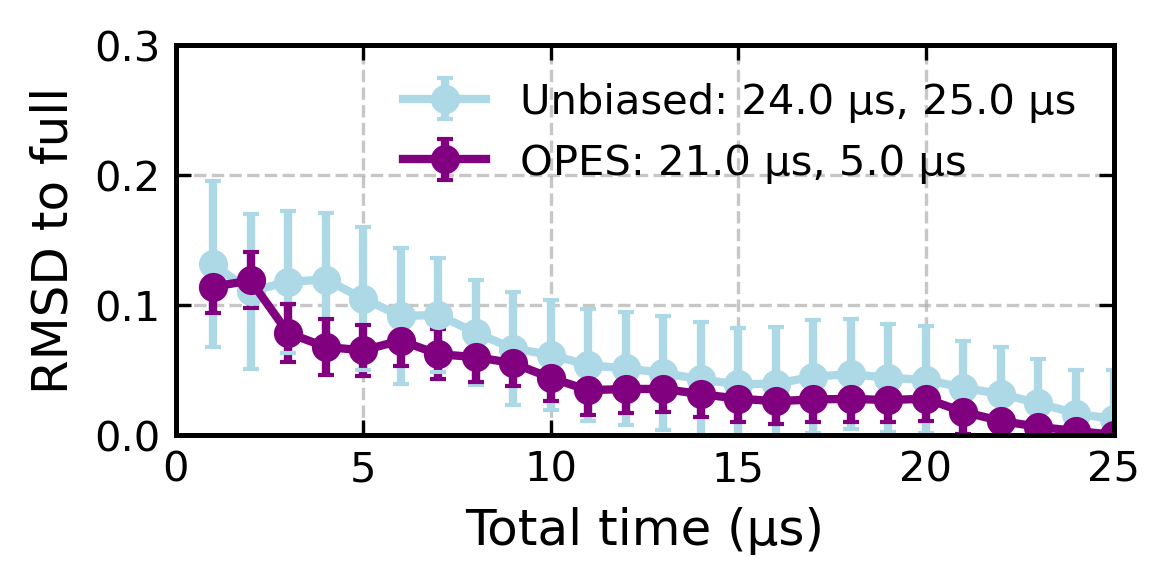

In [16]:
# time convergence of helicity profile across sequence (RMSD of per-residue fraction helix relative to final ensemble and average error of non-zero helicity residues)

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nreplicas = 1
nsims_unb = 3
nrep_opes = 5
total_length_us = 25

times = np.arange(1.0, 25.0 + 1.0, 1.0) # times to check in μs

averages = []
errors = []
error_errors = []

# reference helicity profile
ref = pd.read_csv(output_path+f"{prod_name}_perres_helicity.csv")
# exclude last 4 dssp characters due to weird pdb formatting of the DESRES traj
for time in times:

    for sim in range(nsims_unb):
        if sim==0:
            # load data and concatenate       
            with open(path+f'dssp{sim}.dat') as f:
                dssp = [line.strip()[:-4] for line in f]
            dssp =  np.array(dssp)
        else:
            # load data and concatenate       
            with open(path+f'dssp{sim}.dat') as f:
                tmpdssp = [line.strip()[:-4] for line in f]
            tmpdssp =  np.array(tmpdssp)
            dssp = np.concatenate((dssp, tmpdssp), axis=0)
    # Time arrays in μs
    time_data = np.arange(len(dssp))/1e3       # ps -> μs
    # Apply cutoff at time
    mask_data = time_data <= time
    dssp =  np.array(dssp)[mask_data]
        
    H = dssp_to_helicity(dssp)
    avg_profile = np.average(H, axis=0)
    rmsd = np.sqrt( np.mean( (avg_profile - np.array(ref['Fraction helix']) )**2 ))
    averages.append(rmsd)

    # error analysis
    n_frames, n_residues = H.shape
    stderr = np.zeros(n_residues)

    for j in range(n_residues):
        series = H[:, j]  # helicity time series for residue j
        if np.mean(series)==0:
            stderr[j] = float(0)
            continue
        reblock_data = pyblock.blocking.reblock(series)
        try:
            optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
            if optimal==len(reblock_data)-1:
                optimal = optimal-1
        except:
            allerrs = np.array([reblock_data[ele].std_err for ele in range(len(reblock_data))])
            optimal = np.where(allerrs==np.max(allerrs))[0][0]
        if optimal==len(reblock_data)-1:
            optimal=optimal-1
        stderr[j] = reblock_data[optimal].std_err

    # average and standard deviation of per-residue errors (for non-zero fraction helix)
    avg_mask = avg_profile!=0
    errors.append(np.mean(stderr[avg_mask]))
    error_errors.append(np.std(stderr[avg_mask]))


# save results
df = pd.DataFrame()
df['Time (μs)'] = np.round(times, 3)
df['RMSD per-res helicity'] = np.round(averages, 5)
df['Avg. ±'] = np.round(errors, 5)
df['S.d. ±'] = np.round(error_errors, 5)
df.to_csv(output_path+f'{prod_name}_perres_helicity_vs_time_convergene_{T}K.csv')

# convergence times
conv_val, conv_err = md_stabilization_times_helixprofilermsd(times*nreplicas, averages, errors)

# load opes results
dfopes = pd.read_csv(opes_data_path+f'300K_perres_helicity_vs_time_convergene_{T}K.csv')
conv_val_opes, conv_err_opes = md_stabilization_times_helixprofilermsd(dfopes['Time (μs)']*nrep_opes, dfopes['RMSD per-res helicity'], dfopes['Avg. ±'])

# plot results
plt.figure(figsize = (4, 3.5))

ticks=np.round(np.arange(0, total_length_us+total_length_us//5, total_length_us//5), 0)

plt.subplot(2,1,1)
plt.errorbar(times * nreplicas, averages, errors, fmt= 'o-', color ='lightblue', capsize = 2, label = f'Unbiased: {conv_val:.1f} μs, {conv_err:.1f} μs')
plt.errorbar(dfopes['Time (μs)']*nrep_opes, dfopes['RMSD per-res helicity'], dfopes['Avg. ±'], fmt= 'o-', color ='purple', capsize = 2, label = f'OPES: {conv_val_opes:.1f} μs, {conv_err_opes:.1f} μs')
plt.xlim(0, 25)
plt.ylim(0., 0.3)
plt.ylabel('RMSD to full')
plt.xticks(ticks=ticks, labels = ticks)
plt.xlabel('Total time (μs)')
plt.legend() 

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_helicity_vs_time_convergene_{T}K.pdf")

